In [74]:
import sys
%pylab
%matplotlib inline
import seaborn as sns
from conf_analysis.behavior import empirical, ideal_obs as io
from scipy.stats import norm

sns.set_style('ticks')
%load_ext autoreload
%autoreload 2
data = empirical.data_cleanup(empirical.load_data())

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/nwilming/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [78]:
def pdf(x,s):
    return (x/float(sum(x)))/diff(s)[0]

Step 1: Generate a relaistic prior and Likelihood that depends only on $\mu$ and $\sigma$
==================================

Fortunately it appears that $\bar\mu$ and $\bar\sigma$, i.e. the mean and std estimates from a set of samples from a normal distribution, are independent. This implies that the joint distribution $P(\bar\mu, \bar\sigma | Data)$ can be modelled by the two individual sampling distributions. 

Assuming that we draw samples from $Data = \mathcal{N}(\mu, \sigma)$, the individual sampling distributions of $\bar\mu$ and $\bar\sigma$ are:
    
$$P(\bar\mu | \mu, N=10) = \mathcal{N}(\bar\mu, \mu, \sigma^{\frac{1}{2}}/10)$$
$$P(\bar\sigma | \sigma, N=10) = {\chi^2}(g'(\bar\sigma), 10)\frac{dg'(S)}{dS}$$

Let's make sure that this is actually the case.

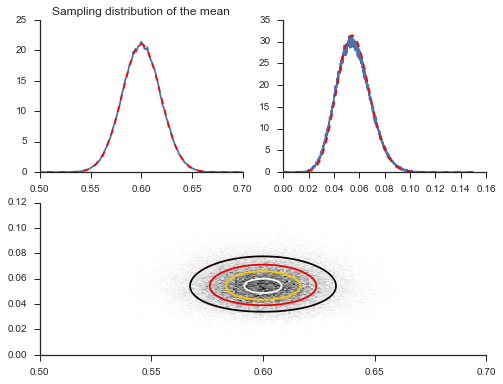

In [184]:
figure(figsize=(8, 6))
gs = matplotlib.gridspec.GridSpec(2,2)
sigma = 0.06
samples = norm.rvs(.6, sigma, size=(10, 350000))
means, sigmas = samples.mean(0), samples.std(0)
xm = linspace(0, 1, 1000)
xs = linspace(0, .15, 1000)
subplot(gs[0,0])
plot(io.center(xm), pdf(histogram(means, bins=xm)[0], xm))
plot(xm, io.mdist(xm, .6, sigma), 'r--')
xlim([0.5, 0.7])
title('Sampling distribution of the mean')
sns.despine()

subplot(gs[0,1])
plot(io.center(xs), pdf(histogram(sigmas, bins=xs)[0], xs))
plot(xs, io.sdist(xs, sigma, n=10), 'r--')
sns.despine()

subplot(gs[1,:])
MU, SIGMA = meshgrid(xm, xs)
Z = io.likelihood(MU, SIGMA, .6, sigma)
a,b,c = histogram2d(means, sigmas, bins=[xm, xs])
pcolormesh(b,c, a.T)
contour(MU, SIGMA, Z, 4, cmap='hot')
xlim(0.5, 0.7)
ylim(0, 0.12)

sns.despine()

Due to the independence property the joint likelihood is then:

$$ LL(\bar\mu, \bar\sigma | \mu, \sigma) = P(\bar\mu, \bar\sigma | N=10)$$
 
In our experiment the samples come from one of six normal distributions (three variances centered on +- threshold):

$$LL^{t+} = LL(\bar\mu, \bar\sigma | t, 0.05) + LL(\bar\mu, \bar\sigma | t, 0.1)+ LL(\bar\mu, \bar\sigma | t, 0.15)$$
$$LL^{t+} = \sum_{\sigma \in \{0.05, 0.1, 0.15\}} LL(\bar\mu, \bar\sigma | t, \sigma)$$

And since the threshold continously changes throughout the experiment we have to integrate over all possible thresholds:
$$LL^{t+} = \sum_{t\in T} w_t \sum_{\sigma \in \{0.05, 0.1, 0.15\}} LL(\bar\mu, \bar\sigma | t+0.5, \sigma)$$

where $T$ is the set of thresholds that occured and $w_t$ is the thresholds weight normalized such that $\sum_t w_t = 1$. The prior distribution is then the combination of the likelihood for positive and negative thresholds:
  
$$P(\bar\mu, \bar\sigma) = \frac{1}{2}(LL^{t+} + LL^{t-})$$

Let's compare this to the actual distribution.

In [206]:
MU, SIGMA = meshgrid(linspace(0, 1, 250), linspace(0., .3, 250))
Cl = io.make_prior(MU, SIGMA, data.contrast.values)
Cs = io.make_prior(MU, SIGMA, -data.contrast.values)
prior = (Cl+Cs)/2.

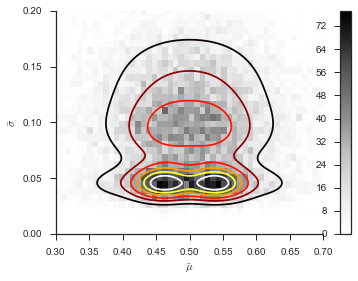

In [209]:
xm, xs = linspace(.3, .7, 51), linspace(0, .3, 51)
a,b,c = histogram2d(data.mc, data.stdc, bins=[xm, xs], normed=True)
pcolormesh(b,c,a.T)
colorbar()
contour(MU, SIGMA, prior, [10, 20, 30, 40, 50, 60], cmap='hot')
xlim([.3, .7])
ylim([0, 0.2])
xlabel(r'$\bar\mu$')
ylabel(r'$\bar\sigma$')
sns.despine()

Step 2: Define posterior probability
====================================

The posterior distribution of whether or not a 'Larger' or 'Smaller' response is correct is given by Bayes theorem:

$$P(Larger | \bar\mu, \bar\sigma) = \frac{P(\bar\mu, \bar\sigma | Larger)  P(Larger)}{P(\bar\mu, \bar\sigma)}$$

With above definitions we get:

$$P(\bar\mu, \bar\sigma | Larger) = LL^{t+}\\
P(Larger) = \frac{1}{2}\\
P(\bar\mu, \bar\sigma) =  \frac{1}{2}(LL^{t+} + LL^{t-})$$

Therefore:
$$P(Larger | \bar\mu, \bar\sigma) = \frac{\frac{1}{2}LL^{t+}}{\frac{1}{2}(LL^{t+} + LL^{t-})}$$

This can be plotted as a 2D surface:

In [214]:
posterior = log(Cl*.5)-log(prior)
posterior_s = log(Cs*.5)-log(prior)

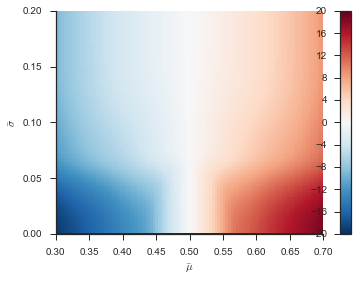

In [222]:
xm, xs = linspace(.3, .7, 51), linspace(0, .3, 51)
#a,b,c = histogram2d(data.mc, data.stdc, bins=[xm, xs])
#pcolormesh(b,c,a.T)
pcolormesh(MU, SIGMA, posterior-posterior_s, cmap='RdBu_r', vmin=-20, vmax=20)
colorbar()
xlim([.3, .7])
ylim([0, 0.2])
xlabel(r'$\bar\mu$')
ylabel(r'$\bar\sigma$')
sns.despine()


In [350]:
def log_posterior(MU, SIGMA, thresholds, stds=[0.05, 0.1, 0.15]):
    Cl = io.make_prior(MU, SIGMA, thresholds, stds=stds)
    Cs = io.make_prior(MU, SIGMA, -thresholds, stds=stds)
    prior = (Cl+Cs)/2.
    #sCl = sCl[MU<0.5].sum()
    Cl[MU<0.5] = 0#finfo(float).eps
    Cs[MU>0.5] = 0#finfo(float).eps
    posterior = log(Cl*.5)-log(prior)
    posterior_s = log(Cs*.5)-log(prior)
    return Cl, prior, posterior-posterior_s

In [351]:
Cl, prior, posterior = log_posterior(MU, SIGMA, array([0.1]), stds=linspace(0.05, 1, 11))

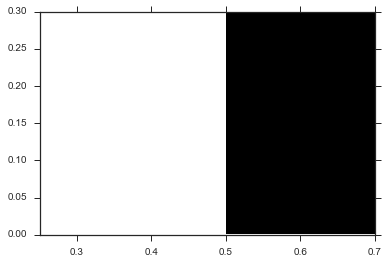

In [357]:
pcolormesh(MU, SIGMA, np.ma.masked_invalid(sign(posterior)))

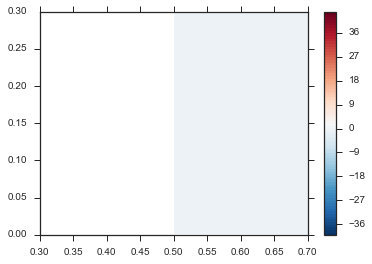

In [336]:
MU, SIGMA = meshgrid(linspace(0.3, .7, 250), linspace(0., .3, 250))
contourf(MU, SIGMA, 
           np.ma.masked_invalid(log_posterior(MU, SIGMA, array([0.1]), stds=linspace(0.05, 1, 11))),
           arange(-40, 45, 1),
           cmap='RdBu_r')
colorbar()